In [2]:
#!pip install --upgrade h5py

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Amit\\AppData\\Local\\Temp\\pip-uninstall-g0c2ptbx\\h5.cp38-win_amd64.pyd'



  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Consider using the `--user` option or check the permissions.



In [1]:
# Importing to liberaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Flatten, Dropout
import cv2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Reading in data
train_dir = "C:\\Users\\Amit\\Desktop\\ML Projects\\Chest X-ray Pnumonia\\Data\\train"
test_dir = "C:\\Users\\Amit\\Desktop\\ML Projects\\Chest X-ray Pnumonia\\Data\\test"
val_dir = "C:\\Users\\Amit\\Desktop\\ML Projects\\Chest X-ray Pnumonia\\Data\\val"
categories = os.listdir(train_dir)

# Extract to dataframe

In [3]:
# Creating Training df with file path, fine name, and class as variables
paths= []
category_list=[]
file = []
for cate in categories:
    path = os.path.join(train_dir, cate)
    
    for img in os.listdir(path):
        paths.append(os.path.abspath(img))
        category_list.append(cate)
        file.append(img)
        
df_train = pd.DataFrame({'Paths' :paths, 'File':file ,'Category':category_list})
df_train.head()

,Paths,File,Category
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0115-0001.jpeg,NORMAL
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0117-0001.jpeg,NORMAL
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0119-0001.jpeg,NORMAL
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0122-0001.jpeg,NORMAL
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0125-0001.jpeg,NORMAL


In [4]:
# Creating Test df with file path, fine name, and class as variables
paths= []
category_list=[]
file = []
for cate in categories:
    path = os.path.join(test_dir, cate)
    
    for img in os.listdir(path):
        paths.append(os.path.abspath(img))
        category_list.append(cate)
        file.append(img)
        
df_test = pd.DataFrame({'Paths' :paths, 'File':file ,'Category':category_list})
df_test.head()

,Paths,File,Category
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL


In [5]:
# Creating Validation df with file path, fine name, and class as variables
paths= []
category_list=[]
file = []
for cate in categories:
    path = os.path.join(val_dir, cate)
    
    for img in os.listdir(path):
        paths.append(os.path.abspath(img))
        category_list.append(cate)
        file.append(img)
        
df_val = pd.DataFrame({'Paths' :paths, 'File':file ,'Category':category_list})
df_val.head()

,Paths,File,Category
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0335-0001.jpeg,NORMAL
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0339-0001.jpeg,NORMAL
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0377-0001.jpeg,NORMAL
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0740-0001.jpeg,NORMAL
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,NORMAL2-IM-0439-0001.jpeg,NORMAL


## Generators

In [6]:
batch_size = 20
image_size = 450
input_shape = (450,450,1)

#### Train set generator

In [7]:
# Creating a Generator to input data into the model
# Performing some data auigmentation as well

train = ImageDataGenerator(rescale=1/155,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [8]:
# CHecking the 2 class catagories
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Val set generator

In [9]:
# Creating a Generator to input data into the model
# Performing some data auigmentation as well

valid = ImageDataGenerator(rescale=1/155)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


#### Test set generator

In [10]:
# Creating a Generator to input data into the model
# Performing some data auigmentation as well

test = ImageDataGenerator(rescale=1/155)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


#### Call Back Functions

In [11]:
# Defining call backs for early stoping
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

# Model building
## Model 1

In [12]:
model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 450, 450, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 450, 450, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 225, 225, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 225, 225, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 225, 225, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 225, 225, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0

In [13]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/100
260/260 [==============================] - 83s 285ms/step - loss: 18.5320 - accuracy: 0.8970 - val_loss: 11.8898 - val_accuracy: 0.6042
Epoch 2/100
260/260 [==============================] - 70s 270ms/step - loss: 1.1837 - accuracy: 0.9383 - val_loss: 2.9353 - val_accuracy: 0.8125
Epoch 3/100
260/260 [==============================] - 69s 265ms/step - loss: 0.3480 - accuracy: 0.9473 - val_loss: 1.1571 - val_accuracy: 0.8125
Epoch 4/100
260/260 [==============================] - 70s 269ms/step - loss: 0.1999 - accuracy: 0.9560 - val_loss: 1.4383 - val_accuracy: 0.8125
Epoch 5/100
260/260 [==============================] - 70s 269ms/step - loss: 0.1429 - accuracy: 0.9570 - val_loss: 6.9081 - val_accuracy: 0.5417
Epoch 6/100
260/260 [==============================] - 70s 269ms/step - loss: 0.1157 - accuracy: 0.9620 - val_loss: 0.9301 - val_accuracy: 0.7917
Epoch 7/100
260/260 [==============================] - 70s 268ms/step - loss: 0.1095 - accuracy: 0.9633 - val_loss: 15.405

In [ ]:
plt.plot(history.history['loss'])

## Predict on test

In [ ]:
pred = model.predict(test_data)

#### Pred df model 1

In [ ]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [ ]:
model1_pred = df_test.copy()

model1_pred['actual'] = model1_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model1_pred['Pred_proba_Normal'] = zero_index_pred
model1_pred['class_pred'] = model1_pred['Pred_proba'].apply(lambda x: 1 if x<0.5 else 0)

model1_pred.head()

In [ ]:
confusion_matrix(model1_pred['actual'], model1_pred['class_pred'])

In [ ]:
accuracy_score(model1_pred['actual'], model1_pred['class_pred'])

In [ ]:
model.save('Model_1.h5')

# Model 2
- Increasing image size to 500 pixels
- adding a 16 layer convolution at the beginning of the cnn
- adding another dense layer of 1024
- will increase batch size to see what fits

In [ ]:
batch_size = 16
image_size = 500
input_shape = (image_size,image_size,1)

### Generators

In [ ]:
train = ImageDataGenerator(rescale=1/155,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
valid = ImageDataGenerator(rescale=1/155)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
test = ImageDataGenerator(rescale=1/155)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

In [ ]:
# Defining call backs
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [ ]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

In [ ]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

In [ ]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [ ]:
pred = model.predict(test_data)

In [ ]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [ ]:
model2_pred = df_test.copy()

model2_pred['actual'] = model2_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model2_pred['Pred_proba_Normal'] = zero_index_pred
model2_pred['class_pred'] = model2_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model2_pred.head()

In [ ]:
confusion_matrix(model2_pred['actual'], model2_pred['class_pred'])

In [ ]:
accuracy_score(model2_pred['actual'], model2_pred['class_pred'])

In [ ]:
model_2 = model.save('model_2.h5')

# Model 3
### ALso just realized that the rescaling factor was 155. It should be 255. Changing that. Ooops
- Decreasing Batch size seemed to increase model performance.
- Will change batch size to 8
- Adding anotheer conv layer of 128
- will increase batch size to see what fits

In [ ]:
batch_size = 8
image_size = 500
input_shape = (image_size,image_size,1)

### Generators

In [ ]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

In [ ]:
# Defining call backs
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [ ]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

In [ ]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

In [ ]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [ ]:
pred = model.predict(test_data)

In [ ]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [ ]:
model3_pred = df_test.copy()

model3_pred['actual'] = model3_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model3_pred['Pred_proba_Normal'] = zero_index_pred
model3_pred['class_pred'] = model3_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model3_pred.head()

In [ ]:
confusion_matrix(model3_pred['actual'], model3_pred['class_pred'])

In [ ]:
accuracy_score(model3_pred['actual'], model3_pred['class_pred'])

- So it seems like complex models perform poorly

# Model 4
- Will build a simpler model

In [ ]:
batch_size = 8
image_size = 500
input_shape = (image_size,image_size,1)

### Generators

In [ ]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

In [ ]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

In [ ]:
# Defining call backs
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [ ]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

In [ ]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

In [ ]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [ ]:
pred = model.predict(test_data)

In [ ]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [ ]:
model4_pred = df_test.copy()

model4_pred['actual'] = model4_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model4_pred['Pred_proba_Normal'] = zero_index_pred
model4_pred['class_pred'] = model4_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model4_pred.head()

In [ ]:
confusion_matrix(model4_pred['actual'], model4_pred['class_pred'])

In [ ]:
accuracy_score(model4_pred['actual'], model4_pred['class_pred'])

- Seemes like a simple model works better

# Model 5
- Looked up models online
- Getting performance of 90+%
- They are using a bit more complex models but a smaller image size
- Trying image size of 250

In [6]:
batch_size = 16
image_size = 250
input_shape = (image_size,image_size,1)

### Generators

In [7]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [8]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


In [9]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


In [10]:
# Defining call backs
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [11]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0

In [12]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/100
324/324 [==============================] - 42s 107ms/step - loss: 0.5431 - accuracy: 0.9107 - val_loss: 6.8163 - val_accuracy: 0.5000
Epoch 2/100
324/324 [==============================] - 31s 96ms/step - loss: 0.1221 - accuracy: 0.9554 - val_loss: 4.3944 - val_accuracy: 0.5417
Epoch 3/100
324/324 [==============================] - 30s 94ms/step - loss: 0.1232 - accuracy: 0.9541 - val_loss: 0.6050 - val_accuracy: 0.8333
Epoch 4/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1037 - accuracy: 0.9632 - val_loss: 0.9241 - val_accuracy: 0.8125
Epoch 5/100
324/324 [==============================] - 30s 93ms/step - loss: 0.1149 - accuracy: 0.9583 - val_loss: 0.4663 - val_accuracy: 0.8333
Epoch 6/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1071 - accuracy: 0.9622 - val_loss: 0.5427 - val_accuracy: 0.8333
Epoch 7/100
324/324 [==============================] - 30s 93ms/step - loss: 0.1045 - accuracy: 0.9618 - val_loss: 1.0069 - val_a

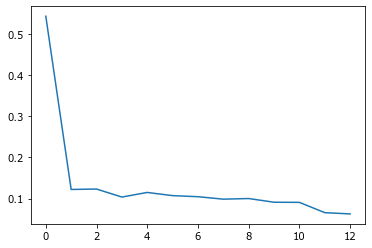

In [13]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [14]:
pred = model.predict(test_data)

In [15]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [16]:
model5_pred = df_test.copy()

model5_pred['actual'] = model5_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model5_pred['Pred_proba_Normal'] = zero_index_pred
model5_pred['class_pred'] = model5_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model5_pred.head()

,Paths,File,Category,actual,Pred_proba_Normal,class_pred
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL,0,0.967120,0
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL,0,0.349138,1
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL,0,0.449169,1
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL,0,0.742099,0
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL,0,0.988462,0


In [17]:
confusion_matrix(model5_pred['actual'], model5_pred['class_pred'])

array([[110, 124],
       [  4, 386]], dtype=int64)

In [18]:
accuracy_score(model5_pred['actual'], model5_pred['class_pred'])

0.7948717948717948

- model performed average

# Model 6
- Will try a bit  more complex model
- will add one more layer of cnn

In [19]:
batch_size = 16
image_size = 250
input_shape = (image_size,image_size,1)

### Generators

In [20]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [21]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


In [22]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


In [23]:
# Defining call backs
early_stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [24]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 250, 250, 16)      160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)       

In [25]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/100
324/324 [==============================] - 31s 93ms/step - loss: 0.3912 - accuracy: 0.9068 - val_loss: 3.0572 - val_accuracy: 0.5000
Epoch 2/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1363 - accuracy: 0.9491 - val_loss: 0.3680 - val_accuracy: 0.8333
Epoch 3/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1287 - accuracy: 0.9504 - val_loss: 0.5611 - val_accuracy: 0.6875
Epoch 4/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1106 - accuracy: 0.9579 - val_loss: 0.8040 - val_accuracy: 0.7500
Epoch 5/100
324/324 [==============================] - 30s 92ms/step - loss: 0.1001 - accuracy: 0.9626 - val_loss: 0.9649 - val_accuracy: 0.7083
Epoch 6/100
324/324 [==============================] - 30s 92ms/step - loss: 0.0785 - accuracy: 0.9732 - val_loss: 0.7391 - val_accuracy: 0.7917
Epoch 7/100
324/324 [==============================] - 30s 92ms/step - loss: 0.0684 - accuracy: 0.9751 - val_loss: 0.6955 - val_ac

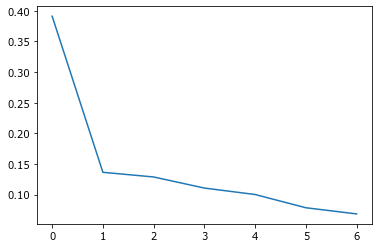

In [26]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [27]:
pred = model.predict(test_data)

In [28]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [29]:
model6_pred = df_test.copy()

model6_pred['actual'] = model6_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model6_pred['Pred_proba_Normal'] = zero_index_pred
model6_pred['class_pred'] = model6_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model6_pred.head()

,Paths,File,Category,actual,Pred_proba_Normal,class_pred
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL,0,0.049802,1
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL,0,0.119644,1
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL,0,0.009082,1
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL,0,0.002190,1
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL,0,0.019208,1


In [30]:
confusion_matrix(model6_pred['actual'], model6_pred['class_pred'])

array([[ 76, 158],
       [  2, 388]], dtype=int64)

In [31]:
accuracy_score(model6_pred['actual'], model6_pred['class_pred'])

0.7435897435897436

#  Model 7
- Trying models with repeated CN layers

In [46]:
batch_size = 16
image_size = 250
input_shape = (image_size,image_size,1)

### Generators

In [47]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [48]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


In [49]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


In [50]:
# Defining call backs
early_stop = EarlyStopping(patience=14)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [51]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 250, 250, 16)      160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 125, 125, 16)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)       

In [52]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/100
324/324 [==============================] - 32s 97ms/step - loss: 0.2310 - accuracy: 0.9155 - val_loss: 1.8567 - val_accuracy: 0.5000
Epoch 2/100
324/324 [==============================] - 34s 105ms/step - loss: 0.1364 - accuracy: 0.9487 - val_loss: 1.2259 - val_accuracy: 0.7500
Epoch 3/100
324/324 [==============================] - 32s 99ms/step - loss: 0.1162 - accuracy: 0.9551 - val_loss: 0.2716 - val_accuracy: 0.8333
Epoch 4/100
324/324 [==============================] - 32s 98ms/step - loss: 0.1084 - accuracy: 0.9620 - val_loss: 3.5340 - val_accuracy: 0.6250
Epoch 5/100
324/324 [==============================] - 32s 98ms/step - loss: 0.0883 - accuracy: 0.9691 - val_loss: 1.3235 - val_accuracy: 0.7500
Epoch 6/100
324/324 [==============================] - 32s 99ms/step - loss: 0.0982 - accuracy: 0.9645 - val_loss: 6.4012 - val_accuracy: 0.5000
Epoch 7/100
324/324 [==============================] - 32s 98ms/step - loss: 0.0699 - accuracy: 0.9738 - val_loss: 0.3838 - val_a

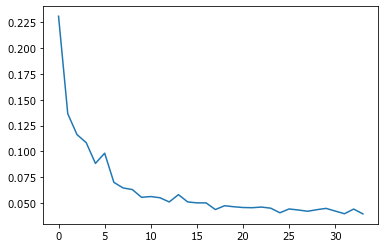

In [53]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [54]:
pred = model.predict(test_data)

In [55]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [56]:
model7_pred = df_test.copy()

model7_pred['actual'] = model7_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model7_pred['Pred_proba_Normal'] = zero_index_pred
model7_pred['class_pred'] = model7_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model7_pred.head()

,Paths,File,Category,actual,Pred_proba_Normal,class_pred
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL,0,0.946312,0
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL,0,0.946622,0
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL,0,0.973942,0
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL,0,0.878912,0
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL,0,0.999556,0


In [57]:
confusion_matrix(model7_pred['actual'], model7_pred['class_pred'])

array([[163,  71],
       [ 16, 374]], dtype=int64)

In [58]:
accuracy_score(model7_pred['actual'], model7_pred['class_pred'])

0.8605769230769231

# Model 8
- Same as model 7 but with a 128 layer cnn

In [59]:
batch_size = 16
image_size = 250
input_shape = (image_size,image_size,1)

### Generators

In [60]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [61]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


In [62]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


In [63]:
# Defining call backs
early_stop = EarlyStopping(patience=14)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [early_stop, reduce_lr]

### Model

In [64]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 250, 250, 16)      160       
_________________________________________________________________
batch_normalization_17 (Batc (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 125, 125, 16)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_18 (Batc (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 32)       

In [65]:
epochs = 100
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/100
324/324 [==============================] - 32s 95ms/step - loss: 0.2608 - accuracy: 0.8993 - val_loss: 5.9948 - val_accuracy: 0.5000
Epoch 2/100
324/324 [==============================] - 30s 94ms/step - loss: 0.1642 - accuracy: 0.9396 - val_loss: 3.5632 - val_accuracy: 0.6250
Epoch 3/100
324/324 [==============================] - 31s 95ms/step - loss: 0.1263 - accuracy: 0.9551 - val_loss: 0.2967 - val_accuracy: 0.8542
Epoch 4/100
324/324 [==============================] - 32s 97ms/step - loss: 0.1172 - accuracy: 0.9581 - val_loss: 2.9615 - val_accuracy: 0.6042
Epoch 5/100
324/324 [==============================] - 32s 99ms/step - loss: 0.1030 - accuracy: 0.9635 - val_loss: 6.4431 - val_accuracy: 0.5000
Epoch 6/100
324/324 [==============================] - 34s 104ms/step - loss: 0.1106 - accuracy: 0.9624 - val_loss: 5.4132 - val_accuracy: 0.5000
Epoch 7/100
324/324 [==============================] - 31s 95ms/step - loss: 0.0847 - accuracy: 0.9676 - val_loss: 0.1568 - val_a

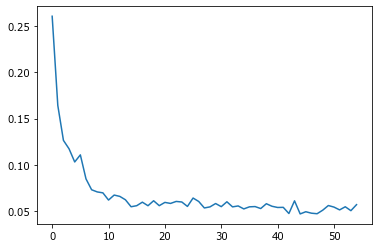

In [66]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [67]:
pred = model.predict(test_data)

In [68]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [69]:
model8_pred = df_test.copy()

model8_pred['actual'] = model8_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model8_pred['Pred_proba_Normal'] = zero_index_pred
model8_pred['class_pred'] = model8_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model8_pred.head()

,Paths,File,Category,actual,Pred_proba_Normal,class_pred
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL,0,0.999914,0
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL,0,0.906134,0
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL,0,0.995976,0
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL,0,0.994590,0
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL,0,0.999805,0


In [70]:
confusion_matrix(model8_pred['actual'], model8_pred['class_pred'])

array([[186,  48],
       [ 16, 374]], dtype=int64)

In [71]:
accuracy_score(model8_pred['actual'], model8_pred['class_pred'])

0.8974358974358975

In [72]:
model_8 = model.save('model_8.h5')

#### Ok so this was the best performing model. About 90% accuracy
- However it took too long to train because of early stoping
- Will use a max of 33 epochs

# Model 9
- Will remove early stoping and put 33 epochs
- will increase compexity (cnn of 256)

In [6]:
batch_size = 16
image_size = 250
input_shape = (image_size,image_size,1)

### Generators

In [7]:
train = ImageDataGenerator(rescale=1/255,
                           rotation_range=15,
                           zoom_range=0.05,
                           horizontal_flip=True,
                          )

train_data = train.flow_from_directory(train_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 5184 images belonging to 2 classes.


In [8]:
valid = ImageDataGenerator(rescale=1/255)

valid_data = valid.flow_from_directory(val_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=True,
                                      )

Found 48 images belonging to 2 classes.


In [9]:
test = ImageDataGenerator(rescale=1/255)

test_data = test.flow_from_directory(test_dir,
                                       target_size=(image_size,image_size),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=batch_size,
                                       shuffle=False,
                                      )

Found 624 images belonging to 2 classes.


In [11]:
# Defining call backs
#early_stop = EarlyStopping(patience=14)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,)


callbacks = [reduce_lr]

### Model

In [13]:
model = Sequential()

model.add(Conv2D(16,(3,3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPool2D(2,2))
model.add(Dropout(0.20))

model.add(Dense(512, activation='relu'))

model.add(Dense(1024, activation='relu'))

model.add(Dense(2048, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 250, 250, 16)      160       
_________________________________________________________________
batch_normalization_8 (Batch (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)       

In [14]:
epochs = 34
history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_data,
                   )

Epoch 1/34
324/324 [==============================] - 37s 96ms/step - loss: 0.2704 - accuracy: 0.8970 - val_loss: 3.9717 - val_accuracy: 0.5000
Epoch 2/34
324/324 [==============================] - 31s 95ms/step - loss: 0.1588 - accuracy: 0.9466 - val_loss: 7.6782 - val_accuracy: 0.5625
Epoch 3/34
324/324 [==============================] - 31s 95ms/step - loss: 0.1571 - accuracy: 0.9444 - val_loss: 0.4199 - val_accuracy: 0.8125
Epoch 4/34
324/324 [==============================] - 30s 94ms/step - loss: 0.1232 - accuracy: 0.9589 - val_loss: 11.9436 - val_accuracy: 0.5208
Epoch 5/34
324/324 [==============================] - 31s 97ms/step - loss: 0.1082 - accuracy: 0.9612 - val_loss: 0.4167 - val_accuracy: 0.8750
Epoch 6/34
324/324 [==============================] - 31s 95ms/step - loss: 0.1018 - accuracy: 0.9585 - val_loss: 0.5108 - val_accuracy: 0.7500
Epoch 7/34
324/324 [==============================] - 31s 96ms/step - loss: 0.1012 - accuracy: 0.9643 - val_loss: 3.5020 - val_accuracy

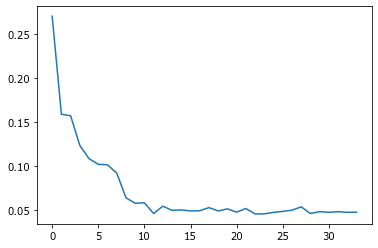

In [15]:
plt.plot(history.history['loss'])

### Prediction and evaluation

In [16]:
pred = model.predict(test_data)

In [17]:
zero_index_pred = []
for l in pred:
    zero_index_pred.append(l[0])

In [18]:
model9_pred = df_test.copy()

model9_pred['actual'] = model9_pred['Category'].apply(lambda x: 0 if x=='NORMAL' else 1)
model9_pred['Pred_proba_Normal'] = zero_index_pred
model9_pred['class_pred'] = model9_pred['Pred_proba_Normal'].apply(lambda x: 1 if x<0.5 else 0)

model9_pred.head()

,Paths,File,Category,actual,Pred_proba_Normal,class_pred
0,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0001-0001.jpeg,NORMAL,0,0.977037,0
1,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0003-0001.jpeg,NORMAL,0,0.838172,0
2,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0005-0001.jpeg,NORMAL,0,0.713298,0
3,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0006-0001.jpeg,NORMAL,0,0.866755,0
4,C:\Users\Amit\Desktop\ML Projects\Chest X-ray ...,IM-0007-0001.jpeg,NORMAL,0,0.986675,0


In [19]:
confusion_matrix(model9_pred['actual'], model9_pred['class_pred'])

array([[145,  89],
       [  5, 385]], dtype=int64)

In [20]:
accuracy_score(model9_pred['actual'], model9_pred['class_pred'])

0.8493589743589743

In [21]:
#model_9 = model.save('model_9.h5')